# KPI sensitivity towards parameter choices

*Danilo Lessa Bernardineli* 

---

This is a practical application of the 'cadCAD_machine_search' library

- `cadcad_machine_search.tools.sweep_cartesian_product` makes it easy to create large-scale simulations
- `cadcad_machine_search.visualizations.plot_kpi_sensitivity` allows to quickly get insights about what parameters matters the most while keeping track of the pathways about how they interact with the system

## Dependences

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from cadCAD.configuration import Experiment
from cadCAD.configuration.utils import config_sim
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor

## Definitions

### Initial conditions and parameters

In [2]:
initial_conditions = {
    'prey_population': 100,
    'predator_population': 15
    }

# The sweep_cartesian_product makes it easy to create large-scale simulations
from cadcad_machine_search.tools import sweep_cartesian_product

PARAMS_TO_SWEEP = {    
    "predator_death_const": np.linspace(0.9, 1.1, 5),
    "prey_death_const": np.linspace(0.02, 0.04, 5),
    "dt": np.linspace(0.04, 0.06, 4)
    }

sweep_params = sweep_cartesian_product(PARAMS_TO_SWEEP)

params = {
    "prey_birth_rate": [1.0],
    "predator_birth_rate": [0.01],
    **sweep_params

}

simulation_parameters = {
    'N': 5,
    'T': range(200),
    'M': params
}

### Policies

In [3]:
def p_predator_births(params, step, sL, s):
  dt = params['dt']
  predator_population = s['predator_population']
  prey_population = s['prey_population']
  birth_fraction = params['predator_birth_rate'] + np.random.random() * 0.0002
  births =  birth_fraction * prey_population * predator_population * dt
  return {'add_to_predator_population': births}


def p_prey_births(params, step, sL, s):
  dt = params['dt']
  population = s['prey_population']
  birth_fraction = params['prey_birth_rate'] + np.random.random() * 0.1
  births =  birth_fraction * population * dt
  return {'add_to_prey_population': births}


def p_predator_deaths(params, step, sL, s):
  dt = params['dt']
  population = s['predator_population']
  death_rate = params['predator_death_const'] + np.random.random() * 0.005
  deaths = death_rate * population * dt
  return {'add_to_predator_population': -1.0 * deaths}


def p_prey_deaths(params, step, sL, s):
  dt = params['dt']
  death_rate = params['prey_death_const'] + np.random.random() * 0.1
  prey_population = s['prey_population']
  predator_population = s['predator_population']
  deaths = death_rate * prey_population * predator_population * dt
  return {'add_to_prey_population': -1.0 * deaths}

### State update functions

In [4]:
def s_prey_population(params, step, sL, s, _input):
    y = 'prey_population'
    x = s['prey_population'] + _input['add_to_prey_population']
    return (y, x)


def s_predator_population(params, step, sL, s, _input):
    y = 'predator_population'
    x = s['predator_population'] + _input['add_to_predator_population']
    return (y, x)

### State update blocks

In [5]:
partial_state_update_blocks = [
    { 
        'policies': {
            'predator_births': p_predator_births,
            'prey_births': p_prey_births,
            'predator_deaths': p_predator_deaths,
            'prey_deaths': p_prey_deaths,
        },
        'variables': {
            'predator_population': s_prey_population,
            'prey_population': s_predator_population
        }
    }
]

### Configuration and Execution

In [6]:
sim_config = config_sim(simulation_parameters)

exp = Experiment()
exp.append_configs(sim_configs=sim_config, 
                   initial_state=initial_conditions,
                   partial_state_update_blocks=partial_state_update_blocks)


from cadCAD import configs
exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.local_mode)
executor = Executor(exec_context=exec_context, configs=configs) 
(records, tensor_field, _) = executor.execute() 


                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

Execution Mode: local_proc
Configuration Count: 100
Dimensions of the first simulation: (Timesteps, Params, Runs, Vars) = (200, 5, 5, 2)
Execution Method: local_simulations
SimIDs   : [0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 8, 8, 8, 8, 8, 9, 9, 9, 9, 9, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 21, 21, 21, 21, 21, 22, 22, 22, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 24, 24, 25, 25, 25, 25, 25, 26, 26, 26, 26, 26, 27, 27, 27, 27, 27, 28, 28, 28, 28, 28, 29, 29, 29, 29, 29, 30, 30, 30, 30, 30, 31, 31, 31, 31, 31, 32, 32, 32, 32, 32, 33

### Results

In [7]:
df = pd.DataFrame(records)

# Drop all intermediate substeps
first_ind = (df.substep == 0) & (df.timestep == 0)
last_ind = df.substep == max(df.substep)
inds_to_drop = (first_ind | last_ind)
df = df.loc[inds_to_drop].drop(columns=['substep'])

# Attribute parameters to each row
df = df.assign(**configs[0].sim_config['M'])
for i, (_, n_df) in enumerate(df.groupby(['simulation', 'subset', 'run'])):
    df.loc[n_df.index] = n_df.assign(**configs[i].sim_config['M'])

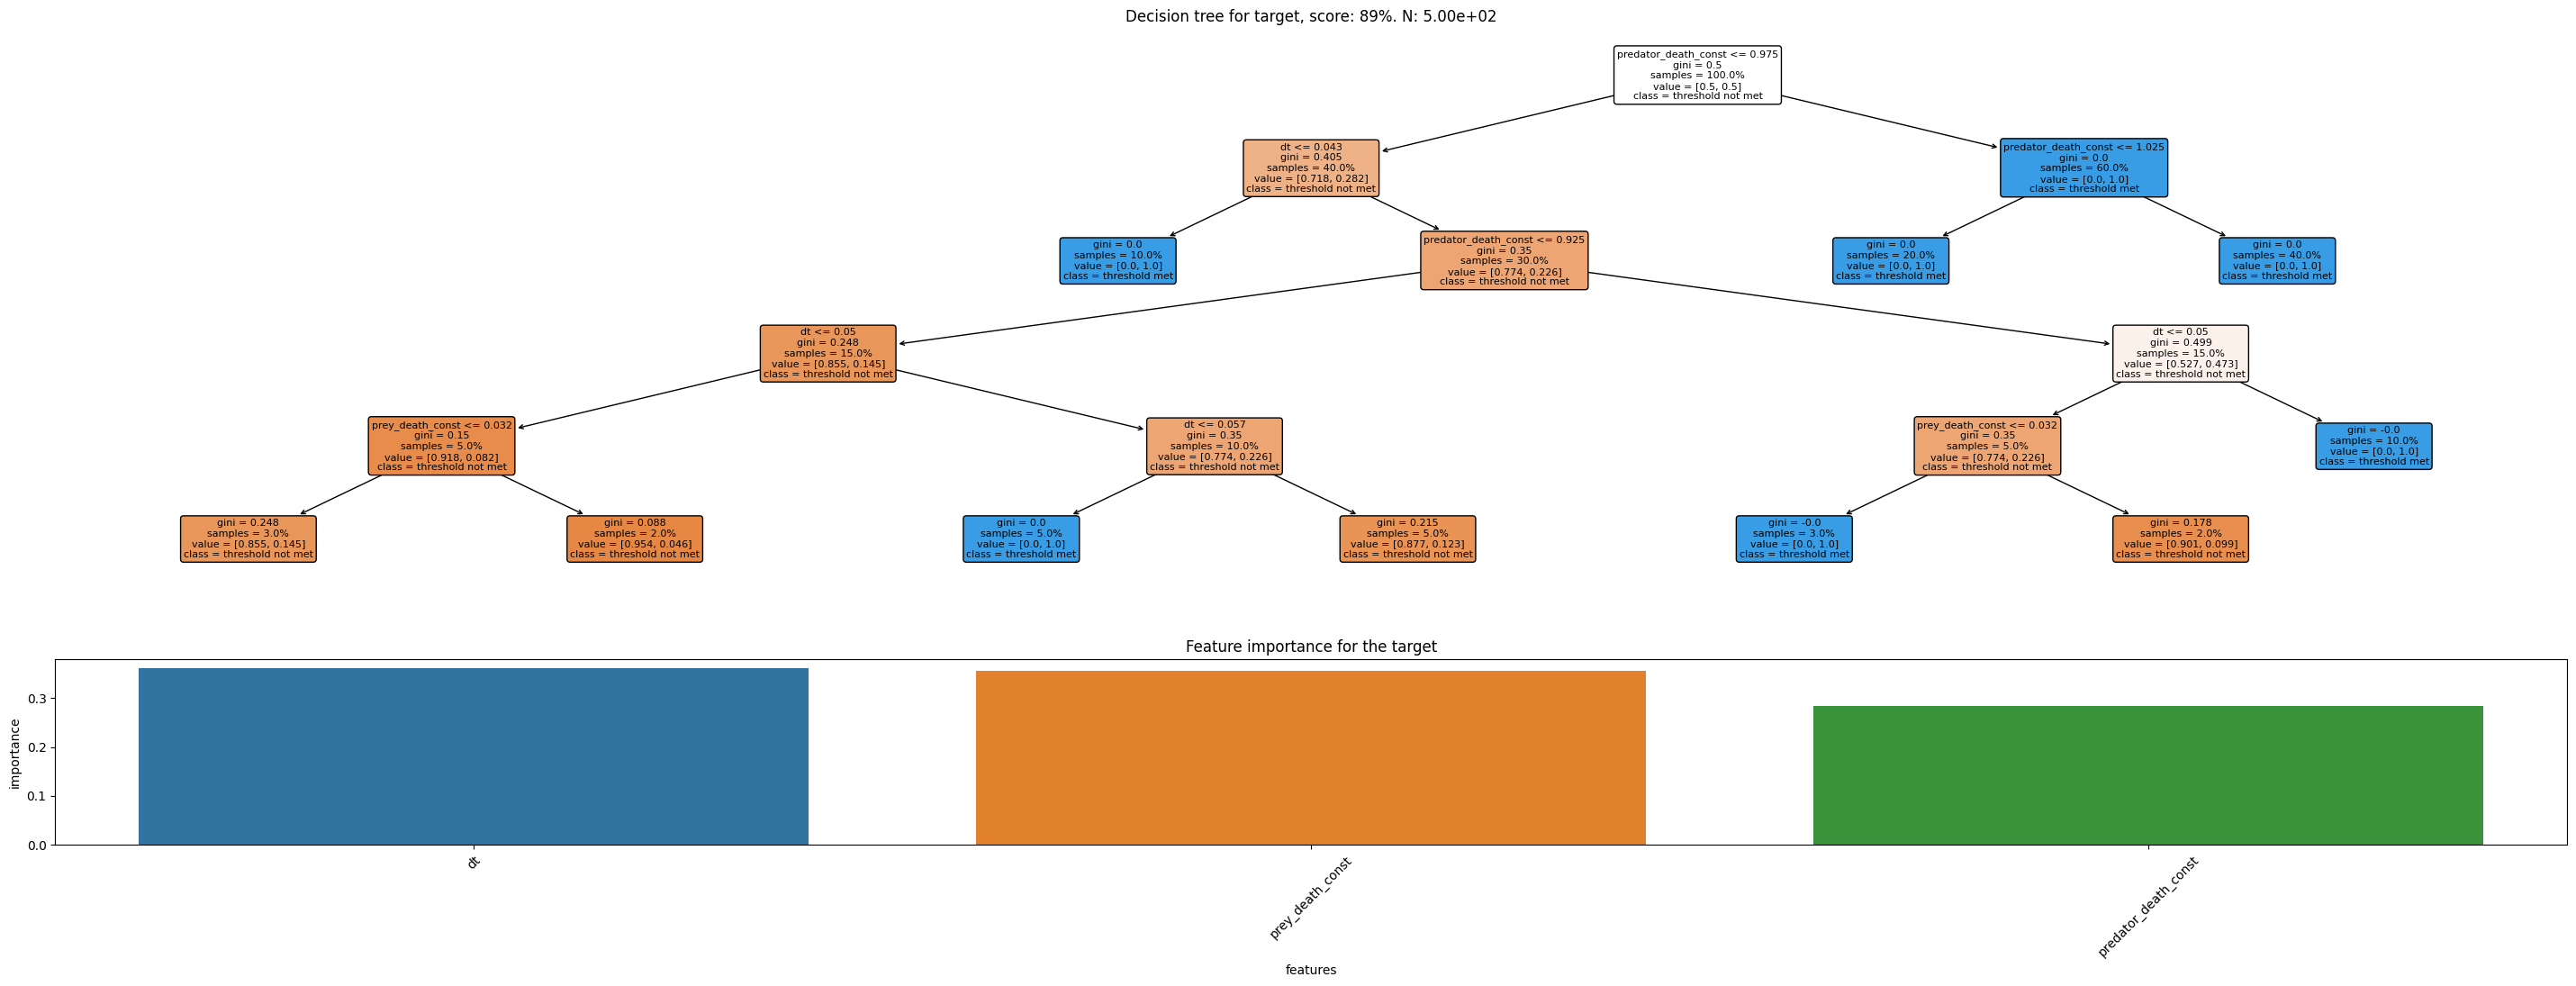

In [8]:
from cadcad_machine_search.visualizations import kpi_sensitivity_plot

# KPI: prey population is 3x above the predator populaton at least 90% of the time
control_params = set(sweep_params.keys())
WEIGHT = 3.0
kpi = lambda df: (df.prey_population > WEIGHT * df.predator_population).mean() > 0.9
kpi_sensitivity_plot(df, kpi, control_params)
